In [5]:
import os
import torch
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

from utils import test_policy_network, seed_everything, plot_stats, plot_action_probs
from parallel_env import ParallelEnv, ParallelWrapper

In [6]:
env = gym.make('CartPole-v0')

In [7]:
dims = env.observation_space.shape[0]
actions = env.action_space.n
print(f'state dim: {dims} / actions: {actions}')
print(f'sample state {env.reset()}')


state dim: 4 / actions: 2
sample state [-0.01332758 -0.03242698  0.04646961  0.04303004]


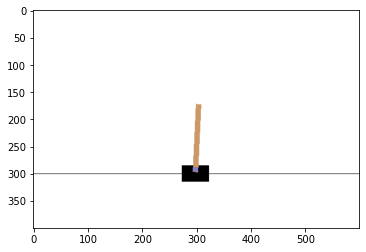

In [8]:
plt.imshow(env.render(mode='rgb_array'))

In [9]:
num_envs = os.cpu_count()

In [10]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env, seed=seed)
    return env

In [11]:
env_fns = [lambda: create_env('CartPole-v0', rank) for rank in range(num_envs)]

# [fn,fn,fn]
parallel_env = ParallelEnv(env_fns)

In [12]:
parallel_env.reset()

array([[-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079]],
      dtype=float32)

In [13]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, parallel_env):
        ParallelWrapper.__init__(self, parallel_env)
        
    #reset
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    #step_async
    def step_async(self, actions):
        # convierte vector columna a vector fila
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
    
    #step_wait
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [14]:
parallel_env = PreprocessEnv(parallel_env)

In [15]:
state = parallel_env.reset()
_, reward, done, _ = parallel_env.step(torch.zeros(num_envs, 1, dtype=torch.int32))
print(f'State: {state}, Reward: {reward}, Done: {done}')

State: tensor([[-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229]]), Reward: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), Done: tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])


In [16]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)

In [17]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

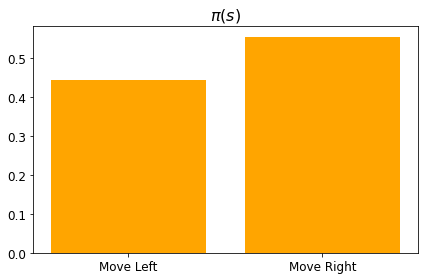

In [18]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

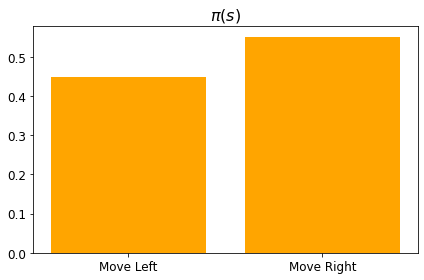

In [19]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

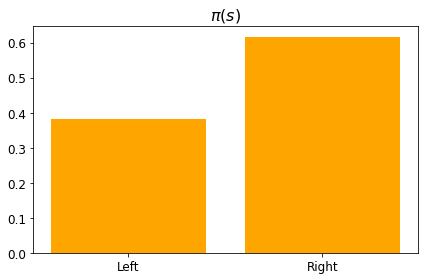

In [20]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

In [21]:
def reinforce(policy, episodes, alpha=1e-4, gamma=0.99):
    
    optim = AdamW(policy.parameters(), alpha)
    stats = {'Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes+1)):
        
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        transitions = []
        ep_return = torch.zeros((num_envs, 1))
        
        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b *reward])
            ep_return += reward
            done_b |= done
            state = next_state
            
        G = torch.zeros((num_envs, 1))
    
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma*G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather(1, action_t)
            
            entropy_t = -torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)
            gamma_t = gamma**t
            
            pg_loss_t = -gamma_t * action_log_prob_t * G
            total_loss_t = (pg_loss_t - 0.01*entropy_t).mean()
            
            policy.zero_grad()
            total_loss_t.backward()
            optim.step()
            
        stats['Loss'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean().item())
        
    return stats

In [22]:
parallel_env.reset()
stats = reinforce(policy, 200)

100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


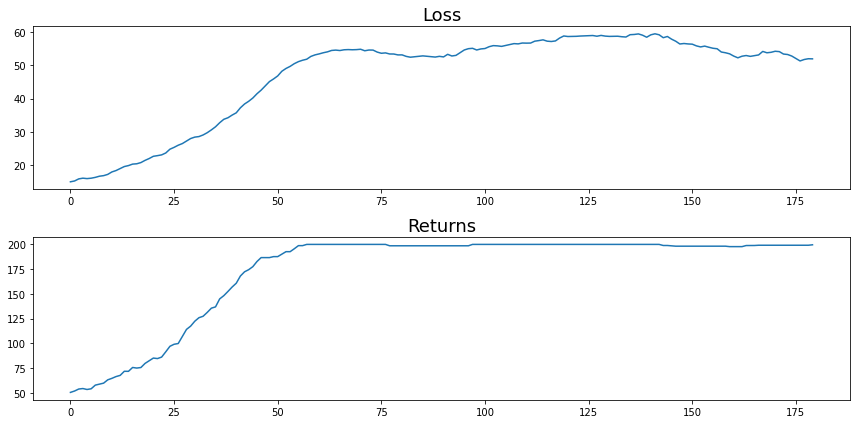

In [23]:
plot_stats(stats)

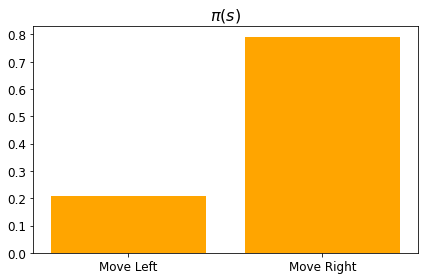

In [25]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

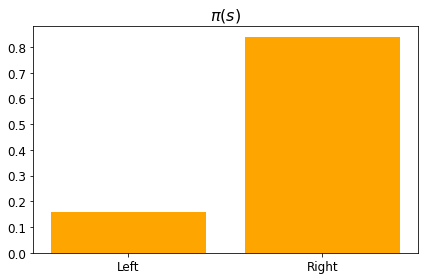

In [26]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

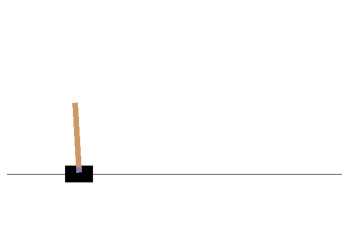

In [27]:
test_policy_network(env, policy, episodes=5)